 # Baseline Forecasting

 ## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
from sklearn.metrics import mean_squared_error
from math import sqrt


In [2]:
np.random.seed(19)
DATA_DIR = 'data/'
DAYS_TO_MINUTES = 24*60
DATA_TYPES = {'CPU', 'MEM'}
SAMPLE_SIZE = 1250//10


In [3]:
DATA = dict()
SAMPLES = dict()


In [4]:
for data_type in DATA_TYPES:
    if data_type not in DATA:
        DATA[data_type] = np.load(DATA_DIR + data_type + '.npy')
        np.random.shuffle(DATA[data_type])

second_data_type = None
for first_data_type in DATA:
    if second_data_type is not None:
        assert DATA[first_data_type].shape == DATA[second_data_type].shape
    second_data_type = first_data_type

assert second_data_type is not None
NO_OF_MACHINES = DATA[second_data_type].shape[0]
NO_OF_TIMESTAMPS = DATA[second_data_type].shape[1]

for data_type in DATA:
    SAMPLES[data_type] = DATA[data_type][:SAMPLE_SIZE]
    

 ## Models

In [9]:
def demo_basic_model(model_func):
    results = list()
    for data_type in SAMPLES:
        X = SAMPLES[data_type][0]
        # split into train and test sets
        train_size = int(len(X) * 0.6)
        test_size = int(len(X) * 0.2)
        validation_size = int(len(X) * 0.2)
        train, test = X[:train_size], X[train_size:train_size+test_size]
        train_X, train_y = train[:-1], train[1:]
        test_X, test_y = test[:-1], test[1:]
        predictions, test_score = model_func(test_X, test_y)
        # plot predictions and expected results
        plt.plot(train_y[-60:], label='Training')
        plt.plot([None for i in train_y[-60:]] + [x for x in test_y[:20]], label='Testing')
        plt.plot([None for i in train_y[-60:]] + [x for x in predictions[:20]], label='Predictions')
        plt.legend()
        plt.show()

        results.append(test_score)
    return results


 ### Persistence

RMSE: 0.025


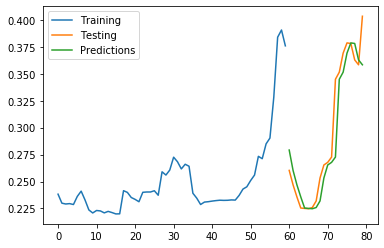

RMSE: 0.057


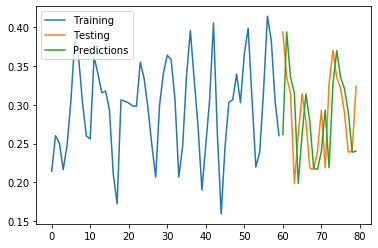

[0.025435785584651937, 0.05680136892666614]

In [10]:
def persistence(test_X, test_y):
    # walk-forward validation
    predictions = list()
    for x in test_X:
        yhat = x
        predictions.append(yhat)
    test_score = sqrt(mean_squared_error(test_y, predictions))
    print('RMSE: %.3f' % test_score)
    return predictions, test_score

demo_basic_model(persistence)


 ### Expanding Window

In [0]:
def expanding_window(test_X, test_y):
# walk-forward validation
    history = [x for x in test_X]
    predictions = list()
    for i in range(len(test_y)):
        # make prediction
        yhat = np.mean(history)
        predictions.append(yhat)
        # observation
        history.append(test_y[i])

    # report performance
    rmse = sqrt(mean_squared_error(test_y, predictions))
    print('RMSE: %.3f' % rmse)
    return predictions, rmse

demo_basic_model(expanding_window)


 ### Rolling Window

In [0]:
def rolling_window(test_X, test_y, w, scores):
    # walk-forward validation
    history = [x for x in test_X]
    predictions = list()
    for i in range(len(test_y)):
        # make prediction
        yhat = np.mean(history[-w:])
        predictions.append(yhat)
        # observation
        history.append(test_y[i])
    # report performance
    rmse = sqrt(mean_squared_error(test_y, predictions))
    scores.append(rmse)
    print('w=%d RMSE:%.3f' % (w, rmse))
    return predictions, rmse


window_sizes = [1, 2, 3, 12, 144, 288, 7*288, 14*288]
scores = list()
for w in window_sizes:
    demo_basic_model(
        lambda test_X, test_y : rolling_window(test_X, test_y, w, scores))

# plot scores over window sizes values
scores_tup = ([scores[i] for i in range(0, len(scores), 2)],
              [scores[i] for i in range(1, len(scores), 2)])
for scores in scores_tup:
    plt.plot(window_sizes, scores)
    plt.show()
